# DCGAN 실습

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content


In [2]:
import torch 
import torch.nn as nn
import torch.optim as optim # pytorch 에서 정의한 수 많은 optimization function 들이 들어 있습니다.
from torch.utils import data

import torchvision # 이미지 관련 처리, Pretrained Model 관련된 Package 입니다.
import torchvision.transforms as T # 이미지 처리 (Vison) 관련된 transformation이 정의 되어 있습니다.
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

## Quiz

In [3]:
#quiz 1 (torch.permute)

sample_array = np.random.randn(2000, 64, 64, 3)
sample = torch.from_numpy(np.array(sample_array))
# sample => (2000, 64, 64, 3).  
# 위 sample 을 (2000, 3, 64, 64)로 바꿔보세요.
#print(sample_1.size())

In [4]:
# 위 sample 을 (2000, 64, 3, 64)로 바꿔보세요.
#print(sample_2.size())

In [5]:
# hint
a = torch.FloatTensor(5,20,100)
a1 = a.permute(0,2,1)
print(a1.shape)
a2 = a.permute(1,2,0)
print(a2.shape)

torch.Size([5, 100, 20])
torch.Size([20, 100, 5])


In [6]:
#quiz 2 (torch.view)

sample = torch.from_numpy(np.array(sample_array))
# sample => (2000, 64, 64, 3).  
#위 sample 을 (2000, 64*64*3)으로 바꿔보세요.
#print(sample_1.size())

#위 sample 을 (2000*64, 64*3)로 바꿔보세요.
#print(sample_2.size())

In [9]:
# hint
a = torch.FloatTensor(5,20,100)
a1 = a.view(2, 10, -1)
print(a1.shape)
a2 = a.view(-1,10, 200)
print(a2.shape)

torch.Size([2, 10, 500])
torch.Size([5, 10, 200])


## Convolution Layer

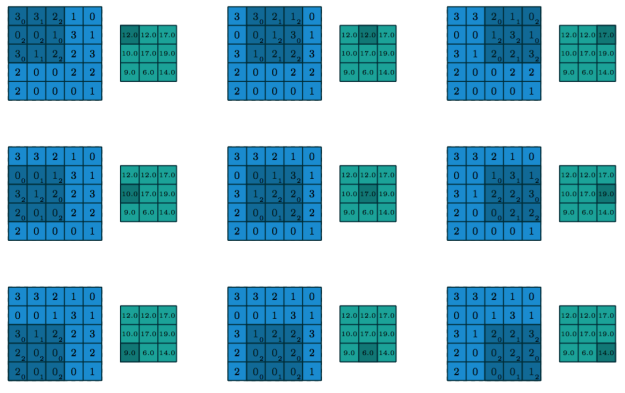

In [ ]:
#quiz 3 (torch.nn.conv)
# nn.Conv2d(in_channel, out_channel, filter_size, stride, padding)
input1 = torch.zeros(16, 3, 64, 64)
conv1 = nn.Conv2d(3, 512, 3, 1, 1)
conv2 = nn.Conv2d(, , 5, ,) # quiz

out = conv1(input1)
out = conv2(out)
print(out.size())
# print(out.size) = (16, 128, 32, 32)

torch.Size([16, 128, 32, 32])


In [ ]:
#quiz 4 (torch.nn.conv)
# nn.Conv2d(in_channel, out_channel, filter_size, stride, padding)
input1 = torch.zeros(16, 3, 64, 64)
conv1 = nn.Conv2d(3, 64, 3, 1, 1)
conv2 = nn.Conv2d(64, , 7, , ) # quiz

out = conv1(input1)
out = conv2(out)
print(out.size())
# print(out.size) = (16, 512, 16, 16)

torch.Size([16, 512, 16, 16])


## Transpose Convolutional Layer

![Transpose Convolution](./imgs/1_Deconv.gif)

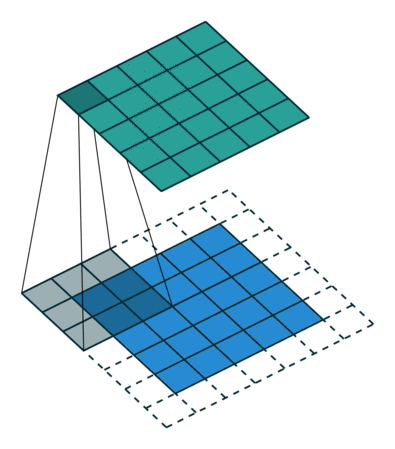

In [12]:
#quiz 5 (torch.nn.ConvTranspose2d)
# nn.Conv2d(in_channel, out_channel, filter_size, stride, pad)
input1 = torch.zeros(16, 100, 1, 1)
conv1 = nn.ConvTranspose2d(100, 512, 4, 2, 1)
conv2 = nn.ConvTranspose2d(512, 256, 4, 2, ) # quiz

out = conv1(input1)
print(out.size())
out = conv2(out)
print(out.size())
# print(out.size()) = (16, 256, 4, 4)

torch.Size([16, 512, 2, 2])
torch.Size([16, 256, 4, 4])


# CIFAR10 DCGAN
## Data Loader 불러오기

In [ ]:
def CIFAR10_DATA(root='./data/', download =True, batch_size=64, num_worker=1):
    print ("[+] Get the CIFAR-10 DATA")
    """
    torchvision.dataset 에는 우리가 많이 사용하는 데이터들을 쉽게 사용할 수 있도록 되어 있습니다.
    """
    transform = T.Compose([T.ToTensor(), # 얻어낸 데이터를 pytorch가 계산 할 수 있는 Tensor 로 변환해 줍니다. 
                           T.Normalize(mean=(0.5, 0.5, 0.5), 
                                       std=(0.5, 0.5, 0.5))])
    
    cifar10_train = datasets.CIFAR10(root = root,  #root 는 데이터의 저장 위치 입니다. 
                                 train = True, #Train 은 이 데이터가 train 데이터인지 아닌지에 대한 정보입니다. 
                                 transform = transform,
                                 download = True)  # 데이터를 다운로드 할지 여부를 물어봅니다. 
    cifar10_test = datasets.CIFAR10(root = root,
                                train = False,  # Test Data를 가져오기에 Train =False 를 줘야 합니다. 
                                transform = transform,
                                download = True)
    """
    Data Loader 는 데이터와 batch size의 정보를 바탕으로 매 iteration 마다 주어진 데이터를 원하는 batch size 만큼 반환해주는 iterator입니다. 
    * Practical Guide : Batch size 는 어느정도가 좋나요? -- 클 수록 좋다는 소리가 있습니다. 하지만 gpu memeory 사이즈 한계에 의해 기본적으로 batch size 가 
    커질 수록 학습에 사용되는 gpu memory 사이즈가 큽니다. (Activation map을 저장해야 하기 때문입니다.) 기본적으로 2의 배수로 저장하는 것이 좋습니다.(Bit size 관련) 
    """
    trainDataLoader = data.DataLoader(dataset = cifar10_train,  # DataSet은 어떤 Data를 제공해 줄지에 대한 정보입니다. 여기서는 Training DATA를 제공합니다. 
                                      batch_size = batch_size, # batch size 정보를 꼭 줘야 합니다. 한 Batch 당 몇 개의 Data 를 제공할지에 대한 정보입니다. 
                                      shuffle =True, # Training의 경우 Shuffling 을 해주는 것이 성능에 지대한 영향을 끼칩니다. 꼭 True 를 줘야 합니다. 
                                      num_workers = num_worker) # num worker의 경우 데이터를 로드하는데 worker를 얼마나 추가하겠는가에 대한 정보입니다. 

    testDataLoader = data.DataLoader(dataset = cifar10_test, # Test Data Loader 이므로 Test Data를 인자로 전달해줍니다.
                                     batch_size = batch_size, # 마찬가지로 Batch size 를 넣어줍니다. 
                                     shuffle = False, # shuffling 이 굳이 필요하지 않으므로 false를 줍니다. 
                                     num_workers = num_worker) #
    print ("[+] Finished loading data & Preprocessing")
    return cifar10_train, cifar10_test, trainDataLoader, testDataLoader

In [ ]:
trainDset, testDset, trainDataLoader, testDataLoader = CIFAR10_DATA(batch_size=64, num_worker=4)  # Data Loader 를 불러 옵니다. 

[+] Get the CIFAR-10 DATA
Files already downloaded and verified
Files already downloaded and verified
[+] Finished loading data & Preprocessing


## CIFAR10 Data 확인

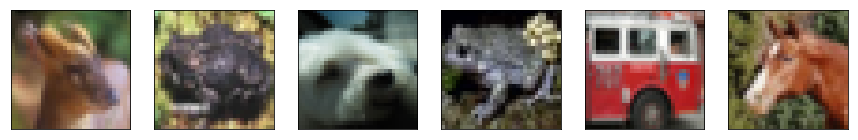

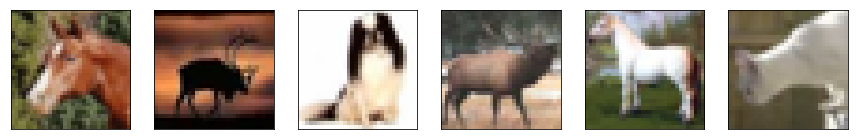

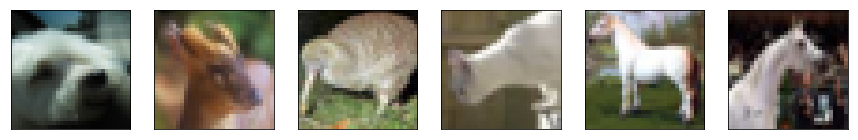

In [ ]:
def show_images(image, n_row):
    for _ in range(n_row):  
        index=np.random.choice(64, 6)
        images =image.numpy()[index]
        plt.figure(figsize=(15,90))    
        for a in range(161, 167):    
            plt.subplot(a)
            plt.imshow(images[(a-161)].transpose(1,2,0))
            plt.xticks([])
            plt.yticks([])    
        plt.show()  

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)
        
for i, (image,_) in enumerate(trainDataLoader):
    show_images(denorm(image.squeeze()), 3)
    break

## Generator, Discriminator

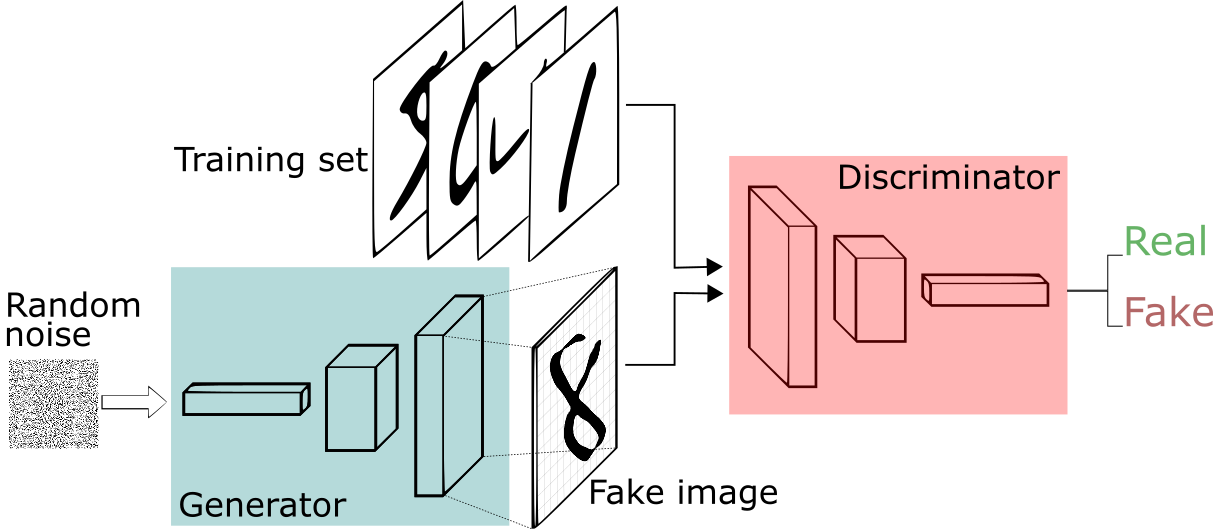

# DCGAN

In [ ]:
'''
코드 단순화를 위한 함수들을 정의해 줍니다.
'''

def conv(c_in, c_out, k_size, stride=2, pad=1, bn=True, activation='lrelu'):
    """ 
    코드 단순화를 위한 convolution block 생성을 위한 함수입니다.
    Conv -> Batchnorm -> Activation function 으로 이어지는 일련의 레이어를 생성합니다.
    """
    layers = []
    
    # Conv.
    layers.append(nn.Conv2d(c_in, c_out, k_size, stride, pad, bias=False))
    
    # Batchnorm
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    
    # Activation
    if activation == 'lrelu':
        layers.append(nn.LeakyReLU(0.2))
    elif activation == 'relu':
        layers.append(nn.ReLU())
    elif activation == 'tanh':
        layers.append(nn.Tanh())
                
    return nn.Sequential(*layers)
  
def deconv(c_in, c_out, k_size, stride=2, pad=1, bn=True, activation='lrelu'):
    """ 
    코드 단순화를 위한 deconvolution block 생성을 위한 함수입니다.
    Deconv -> Batchnorm -> Activation function 으로 이어지는 일련의 레이어를 생성합니다.
    """
    
    layers = []
    
    # Deconv.
    layers.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad, bias=False))
    
    # Batchnorm
    if bn:
    
    # Activation
    if activation == 'lrelu':
        layers.append(nn.LeakyReLU(0.2))
    elif activation == 'relu':
        layers.append(nn.ReLU())
    elif activation == 'tanh':
        layers.append(nn.Tanh())
                
    return nn.Sequential(*layers)

In [ ]:
class Generator(nn.Module):
    """Generator"""
    def __init__(self, z_dim=256, image_size=32, conv_dim=64):
        super(Generator, self).__init__()
        self.fc = deconv(z_dim, conv_dim*4, int(image_size/8), 1, 0, bn=False) # (B, 256, 4, 4)
        self.deconv1 = # (B, 128, 8, 8)
        self.deconv2 = # (B, 64, 16, 16)
        self.deconv3 = deconv(64, 3, 4, bn=False, activation='tanh') # (B, 3, 32, 32)
        
    def forward(self, z):
        z = z.view(z.size(0), z.size(1), 1, 1)
        out = self.fc(z)                            
        out = self.deconv1(out)
        out = self.deconv2(out)
        out = self.deconv3(out)
        return out

In [ ]:
class Discriminator(nn.Module):
    """Discriminator"""
    def __init__(self, image_size=32, conv_dim=64):
        super(Discriminator, self).__init__()
        self.conv1 = # (B, 64, 16, 16)
        self.conv2 = # (B, 128, 8, 8)
        self.conv3 = # (B, 256, 4, 4)
        self.fc = conv(conv_dim*4, 1, int(image_size/8), 1, 0, False)
        
    def forward(self, x):
        out = 
        out = 
        out = 
        out =  # Sigmoid 함수를 사용해야 합니다.
        return out

In [ ]:
# build model
G = Generator(z_dim=256, image_size=32, conv_dim=64).cuda()
D = Discriminator(image_size=32, conv_dim=64).cuda()

## Train DCGAN

Epoch [0/100], Step[300/782], d_loss: 0.6791, g_loss: 1.4211


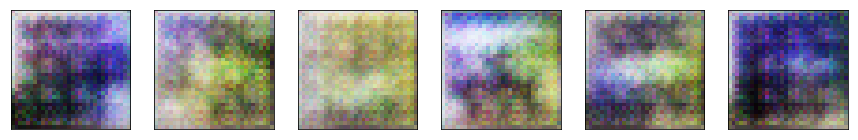

Epoch [0/100], Step[600/782], d_loss: 0.5961, g_loss: 1.0685


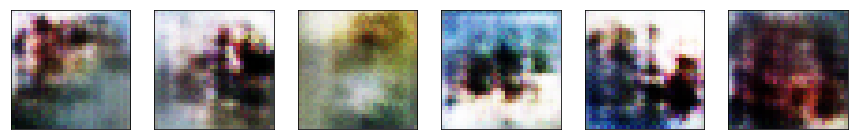

Epoch [1/100], Step[300/782], d_loss: 0.7787, g_loss: 0.9067


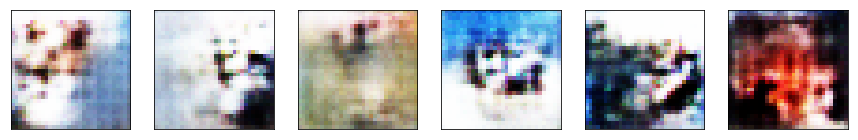

Epoch [1/100], Step[600/782], d_loss: 0.9216, g_loss: 1.3359


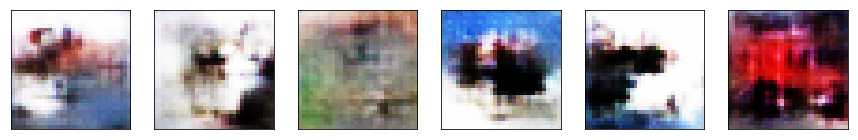

Epoch [2/100], Step[300/782], d_loss: 0.6389, g_loss: 0.8345


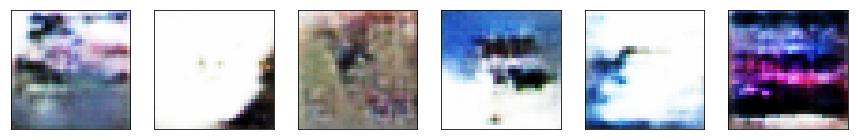

Epoch [2/100], Step[600/782], d_loss: 0.8175, g_loss: 1.0651


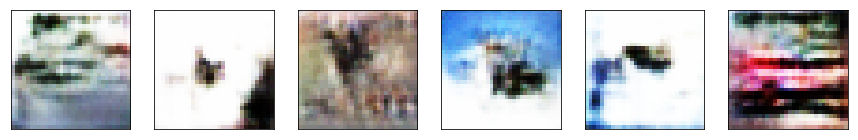

Epoch [3/100], Step[300/782], d_loss: 0.8346, g_loss: 0.9869


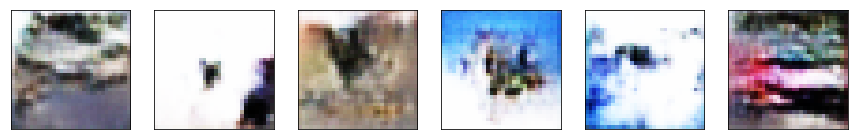

Epoch [3/100], Step[600/782], d_loss: 1.1255, g_loss: 1.2865


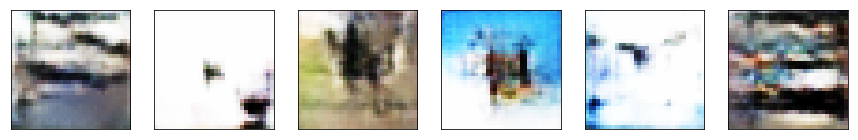

Epoch [4/100], Step[300/782], d_loss: 0.9222, g_loss: 1.0495


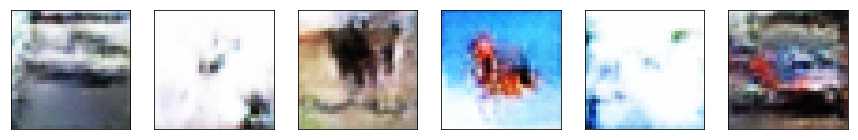

Epoch [4/100], Step[600/782], d_loss: 0.8271, g_loss: 0.9524


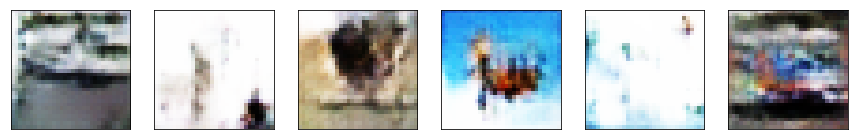

Epoch [5/100], Step[300/782], d_loss: 0.6136, g_loss: 0.9068


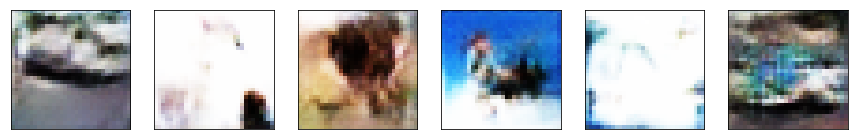

Epoch [5/100], Step[600/782], d_loss: 0.8949, g_loss: 1.0258


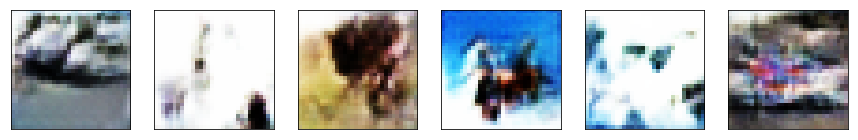

Epoch [6/100], Step[300/782], d_loss: 0.7777, g_loss: 1.3716


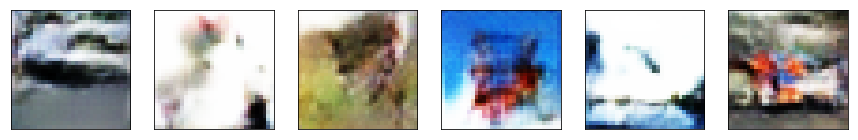

Epoch [6/100], Step[600/782], d_loss: 0.6968, g_loss: 0.9009


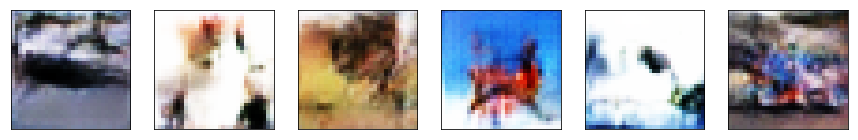

Epoch [7/100], Step[300/782], d_loss: 0.6771, g_loss: 1.1697


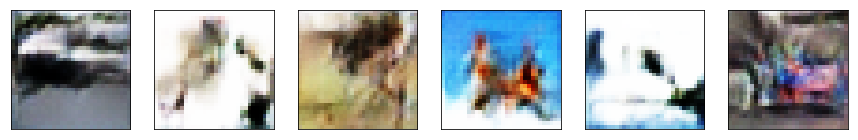

Epoch [7/100], Step[600/782], d_loss: 0.9786, g_loss: 1.2063


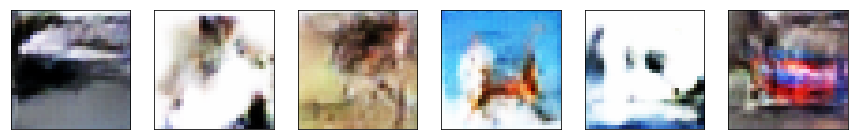

Epoch [8/100], Step[300/782], d_loss: 1.2188, g_loss: 1.2935


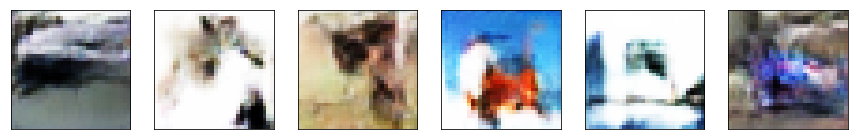

Epoch [8/100], Step[600/782], d_loss: 0.7340, g_loss: 1.0315


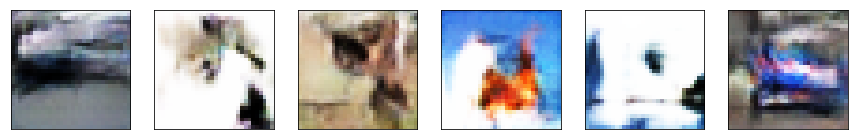

Epoch [9/100], Step[300/782], d_loss: 0.8956, g_loss: 0.8178


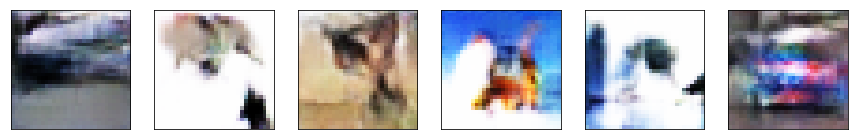

Epoch [9/100], Step[600/782], d_loss: 1.0802, g_loss: 1.1156


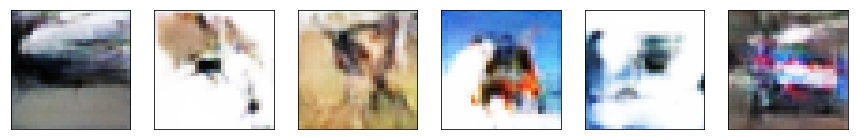

Epoch [10/100], Step[300/782], d_loss: 1.6828, g_loss: 2.3458


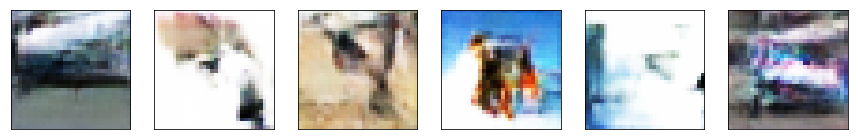

Epoch [10/100], Step[600/782], d_loss: 0.9548, g_loss: 1.3827


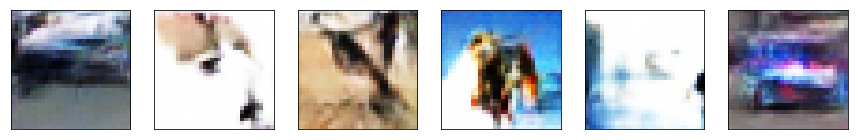

Epoch [11/100], Step[300/782], d_loss: 1.1436, g_loss: 1.3076


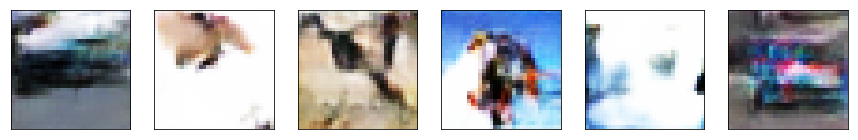

Epoch [11/100], Step[600/782], d_loss: 0.7481, g_loss: 0.8004


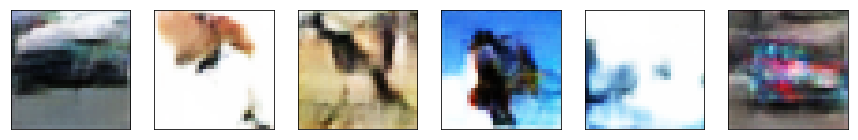

Epoch [12/100], Step[300/782], d_loss: 1.1616, g_loss: 1.0588


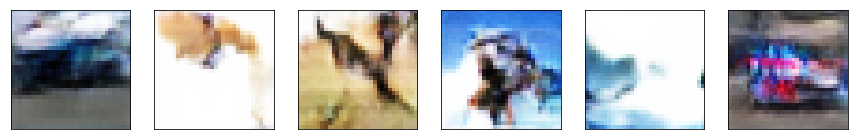

Epoch [12/100], Step[600/782], d_loss: 0.6041, g_loss: 1.0531


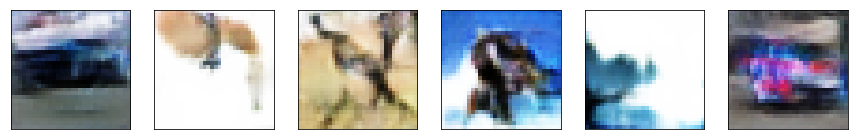

Epoch [13/100], Step[300/782], d_loss: 1.0089, g_loss: 0.9069


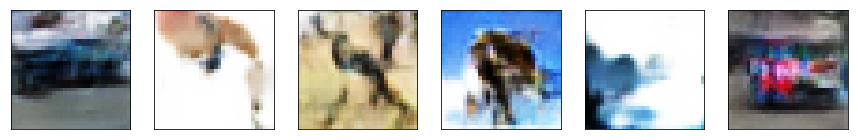

Epoch [13/100], Step[600/782], d_loss: 0.9252, g_loss: 0.8970


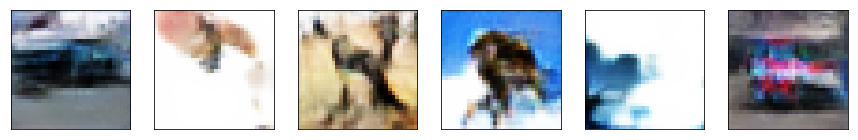

Epoch [14/100], Step[300/782], d_loss: 0.6260, g_loss: 0.9855


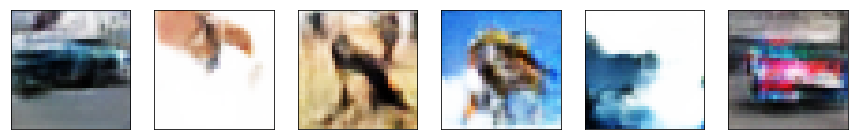

Epoch [14/100], Step[600/782], d_loss: 1.4314, g_loss: 1.3536


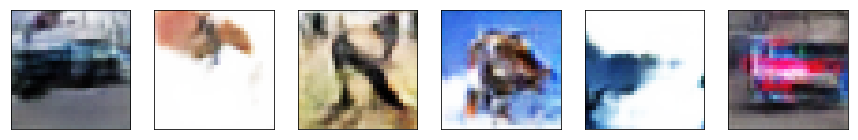

Epoch [15/100], Step[300/782], d_loss: 0.9173, g_loss: 0.7105


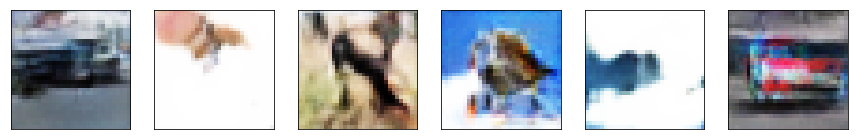

Epoch [15/100], Step[600/782], d_loss: 0.9629, g_loss: 1.2464


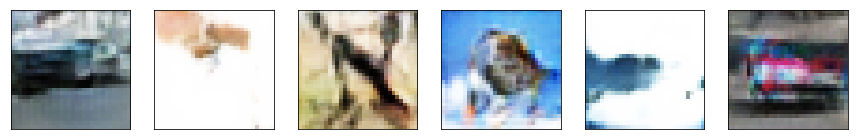

Epoch [16/100], Step[300/782], d_loss: 0.8686, g_loss: 0.8310


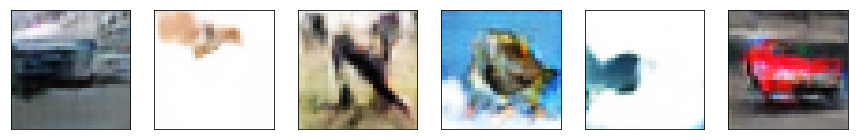

Epoch [16/100], Step[600/782], d_loss: 0.9313, g_loss: 1.2944


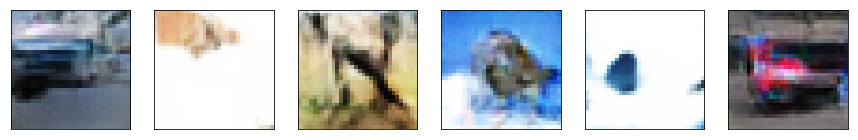

Epoch [17/100], Step[300/782], d_loss: 0.8817, g_loss: 1.1049


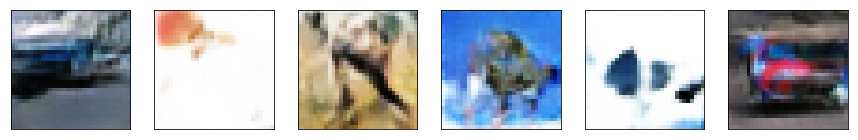

Epoch [17/100], Step[600/782], d_loss: 0.6913, g_loss: 0.8168


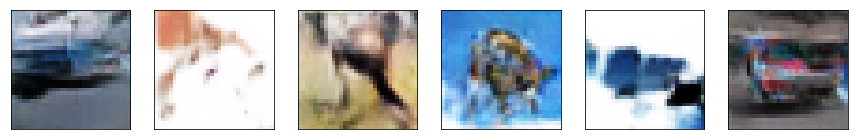

Epoch [18/100], Step[300/782], d_loss: 0.5608, g_loss: 0.9588


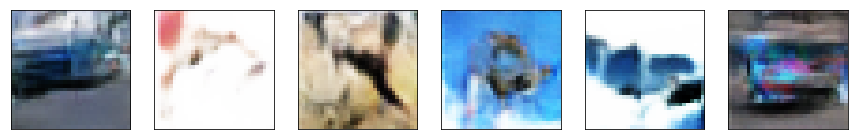

Epoch [18/100], Step[600/782], d_loss: 1.1028, g_loss: 1.2517


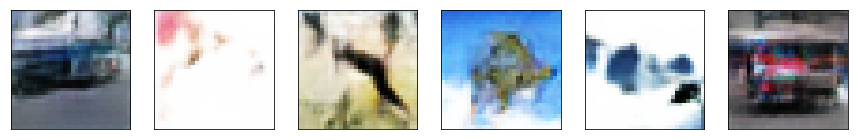

Epoch [19/100], Step[300/782], d_loss: 0.6569, g_loss: 1.0832


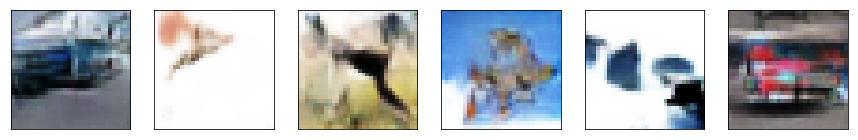

Epoch [19/100], Step[600/782], d_loss: 0.7540, g_loss: 0.8596


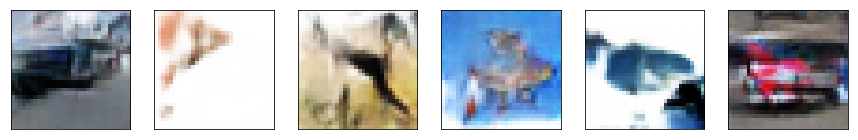

Epoch [20/100], Step[300/782], d_loss: 0.5976, g_loss: 1.0151


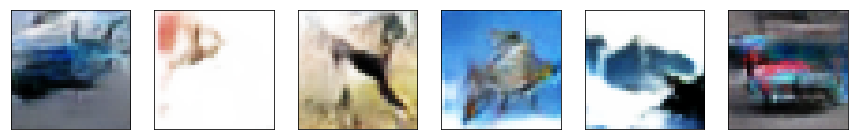

Epoch [20/100], Step[600/782], d_loss: 0.5436, g_loss: 1.2041


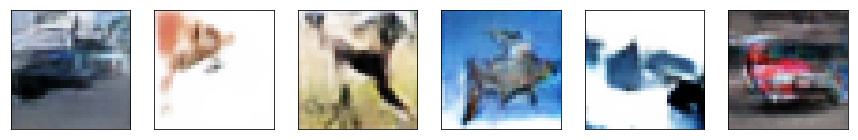

Epoch [21/100], Step[300/782], d_loss: 0.6216, g_loss: 1.0579


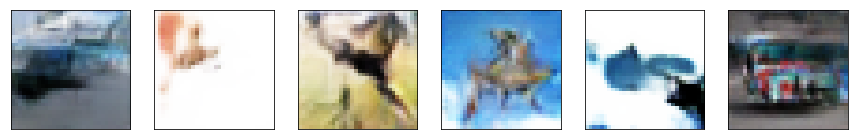

Epoch [21/100], Step[600/782], d_loss: 0.7001, g_loss: 1.1701


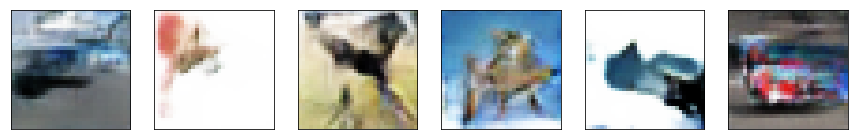

Epoch [22/100], Step[300/782], d_loss: 0.8454, g_loss: 1.0620


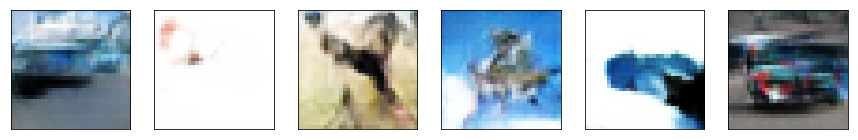

Epoch [22/100], Step[600/782], d_loss: 0.5739, g_loss: 1.1517


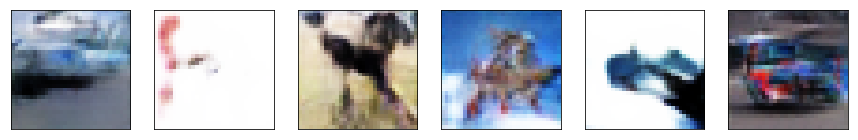

KeyboardInterrupt: 

In [ ]:
# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
g_optimizer = optim.Adam(G.parameters(), 0.0002, [0.5, 0.999]) # learning_rate=0.0002, beta1=0.5, beta2=0.999
d_optimizer = optim.Adam(D.parameters(), 0.0002, [0.5, 0.999]) # learning_rate=0.0002, beta1=0.5, beta2=0.999

fixed_z = torch.randn(6,256).cuda()

# Training
for epoch in range(100):
    for i, (images, _) in enumerate(trainDataLoader):
        G.train()
        D.train()
        
        # Build mini-batch dataset
        batch_size = images.size(0)
        images = images.cuda()
        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size).cuda()
        fake_labels = torch.zeros(batch_size).cuda()

        #============= Train the discriminator =============#
        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels) # Discriminator가 real image를 1(Real)로 예측하도록 학습
        real_score = outputs

        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        z = torch.randn(batch_size, 256).cuda()
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels) # Discriminator가 fake image를 0(Fake)으로 예측하도록 학습
        fake_score = outputs

        # Backprop + Optimize

        #=============== Train the generator ===============#
        # Compute loss with fake images
        z = torch.randn(batch_size, 256).cuda()
        fake_images = G(z)
        outputs = D(fake_images)

        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels) # Generator에서 생성한 fake image가 Discriminator에서 1(Real)로 예측하도록 학습

        # Backprop + Optimize
        G.zero_grad()
        D.zero_grad()        
        g_loss.backward()
        g_optimizer.step()

        if (i+1) % 300 == 0:
            print('======================================================================================================')
            print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, g_loss: %.4f' 
                  %(epoch, 100, i+1, len(trainDataLoader), d_loss.item(), g_loss.item()))
            print('======================================================================================================')
            
            G.eval()
            fake_images = G(fixed_z)
            fake_images = denorm(fake_images)
            
            images_to_show = fake_images.data.cpu().numpy().transpose((0,2,3,1))
            images_row = images_to_show[:6] 

            plt.figure(figsize=(15,75))
            for a in range(161, 167):    
                plt.subplot(a)
                plt.imshow(images_row[a-161])
                plt.xticks([])
                plt.yticks([])
            plt.show()

## Save checkpoints

In [ ]:
torch.save(G.state_dict(),'./model/dcgan_generator.pckl')
torch.save(D.state_dict(),'./model/dcgan_discriminator.pckl')